In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta

# Teaching a quadruped to walk

Time to try out the learning algorithms that you just implemented on a more difficult problem. The WalkerEnv implements a quadruped robot kind-of thing, see for yourself. The goal is to move in the $x$ direction as fast and as far as possible.

Your goal is to implement a class `WalkerPolicy` with function `determine_actions()` just like the StochasticPolicy we used earlier to control the pendulum. Below is a template of this class, but feel free to alter it however you want. The only important thing is the `determine_actions()` function!

After you implement it, copy `WalkerPolicy` into a separate file `WalkerPolicy.py` that you will upload to BRUTE together with the (optional) learned weights in a zip file. How the policy is implemented is up to you! You are constrained to only the libraries we used so far though, such as torch, numpy etc..

You will get some free points just for uploading a working policy (irrelevant of the performance). Further 2 points will be awarded for successfully traversing a small distance in the x direction.


# Hints

There is no single easy way of doing this, but here are some suggestions on what you could try to improve your policy:

1. This problem is much more difficult, than balancing a pendulum. It is a good idea to use a bit larger network than for the pendulum policy.

2. You can also try to use a different optimizer, such as Adam and play with the hyperparameters.

3. Using a neural network to compute the normal distribution scale $\sigma$ can lead to too much randomness in the actions (i.e. exploration). You can use a fixed $\sigma$ instead, or replace it with a learnable `torch.Parameter` initialized to some small constant. Make sure, you run it through an exponential, or softplus function to ensure $\sigma$ is positive.

4. The exploration can also be reduced by penalizing the variance of the action distribution in an additional loss term.

5. If you see some undesirable behaviour, you can tweak the reward function to penalize it. Even though the $x$ distance is all we care about, adding extra terms to the reward can help guide the learning process (This is known as reward shaping). Simply define a reward function mapping the state $s_{t+1}$ and action $a_t$ to a scalar reward $r_t$ and put it in the config dictionary under the key `'reward_fcn'`. See the `WalkerEnv` class for the implementation of the default reward.

6. Using the normal distribution on a bounded action space can lead to certain problems caused by action clipping. This can be mitigated by using a different distribution, such as the Beta distribution. See the `torch.distributions.beta` module for more information. (Note that Beta distribution is defined on the interval [0,1] and works better with parameters $\alpha,\beta \geq 1$.)


In [2]:
# If you cannot run with the visualization, you can set this to False
VISUALIZE = True
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### import self-made modules

In [3]:
from environment.WalkerEnv import WalkerEnv
from WalkerPolicy import WalkerPolicy
import solution

### Define reward function

In [4]:
# DETECT FLIPPING
def rotate_vector_by_quaternion(v, q):
    """
    Rotate the 3D vector v by the quaternion q (w, x, y, z).
    Returns the rotated vector as a numpy array of shape (3,).
    
    The quaternion must be normalized. If not, we do it anyway inside.
    """
    # unpack
    w, x, y, z = q
    # normalize q just in case
    norm_q = np.sqrt(w*w + x*x + y*y + z*z)
    w, x, y, z = w/norm_q, x/norm_q, y/norm_q, z/norm_q

    # v as quaternion: (0, v.x, v.y, v.z)
    vx, vy, vz = v

    # quaternion product q*v
    #  result = q*v = ( w*0 - x*vx - y*vy - z*vz,
    #                   w*vx + x*0 + y*vz - z*vy,
    #                   w*vy - x*vz + y*0 + z*vx,
    #                   w*vz + x*vy - y*vx + z*0 )
    #  but let's do it in a simpler function:
    #  p = (0, vx, vy, vz)
    #  q * p = (w*0 - x*vx - y*vy - z*vz,
    #           w*vx + x*0 + y*vz - z*vy,
    #           w*vy - x*vz + y*0 + z*vx,
    #           w*vz + x*vy - y*vx + z*0)

    # for clarity:
    qw = w
    qx = x
    qy = y
    qz = z

    # first multiply q * p
    tw = - (qx*vx + qy*vy + qz*vz)
    tx =   qw*vx + qy*vz - qz*vy
    ty =   qw*vy - qx*vz + qz*vx
    tz =   qw*vz + qx*vy - qy*vx

    # then multiply (q*p)*q^* => (tw, tx, ty, tz) * (qw, -qx, -qy, -qz)
    #  result is also a quaternion
    # w' = tw*qw - tx*qx - ty*qy - tz*qz
    rw = tw*qw - tx*qx - ty*qy - tz*qz
    rx = tw*(-qx) + tx*qw + ty*(-qz) - tz*(-qy)
    ry = tw*(-qy) - tx*(-qz) + ty*qw + tz*(-qx)
    rz = tw*(-qz) + tx*(-qy) - ty*(-qx) + tz*qw

    # The rotated vector is the (rx, ry, rz) part
    return np.array([rx, ry, rz], dtype=np.float32)



DISTANCE_MULTIPLIER = 0
VELOCITY_MULTIPLIER = 0
ACTION_PENALTY_MULTIPLIER = 0
STABILITY_PENALTY_MULTIPLIER = 1

def walker_reward(state, action):
    pos = state[:15]  # first 15 elements of state vector are generalized coordinates [xyz, quat, joint_angles]
    vel = state[15:]  # last 14 elements of state vector are generalized velocities [xyz_vel, omega, joint_velocities]
    x_velocity = vel[0]  # this is the x axis velocity
    x_distance = pos[0]  # this is the x axis position
    stability_penalty = np.sum(np.abs(vel[1:3]))  # Penalize y and z velocities
    action_penalty = np.sum(np.square(action))  # Penalize large actions
    return (x_distance * DISTANCE_MULTIPLIER + 
            x_velocity * VELOCITY_MULTIPLIER - 
            STABILITY_PENALTY_MULTIPLIER * stability_penalty - 
            ACTION_PENALTY_MULTIPLIER * action_penalty)



# ------------------------------------------------------------------------------------------------
# partial reward shaping for the Walker environment
# ------------------------------------------------------------------------------------------------
def sample_trajectories(env, policy, T, device='cpu'):
    obs_list = env.reset()[0]  
    N = len(obs_list)
    state_dim = len(obs_list[0])
    action_dim = 8

    flip_penalty = 0.0

    obs = torch.tensor(np.stack(obs_list), dtype=torch.float32, device=device)
    states  = torch.zeros((T+1, N, state_dim), device=device)
    actions = torch.zeros((T,   N, action_dim), device=device)
    rewards = torch.zeros((T,   N),            device=device)

    states[0] = obs

    local_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)

    for t in range(T):
        with torch.no_grad():
            a, _, _, _ = policy(states[t])

        actions[t] = a
        a_np = a.cpu().numpy().reshape(-1)

        next_obs_list, env_reward_list = env.vector_step(a_np)
        next_obs = torch.tensor(np.stack(next_obs_list), dtype=torch.float32, device=device)

        custom_rewards = []
        for i in range(N):
            # ------------------------- PENALISE FLIPPING -------------------------
            # parse the quaternion:
            q_wxyz = next_obs_list[i][3:7]  # [w, x, y, z]
            # rotate local_up:
            up_world = rotate_vector_by_quaternion(local_up, q_wxyz)
            # if up_world.z < 0 => flipped
            if up_world[2] < -0.9:
                flip_penalty = -5.0
                #print(f"Robot {i} flipped at time {t}") # debug if this code works
            # -------------------------REWARD ------------------------
            x_pos = next_obs_list[i][0]
            position_reward = 1.0 * x_pos
            x_vel = next_obs_list[i][15]
            forward_reward = 10.0 * x_vel
            # ---------------------- PENALISE GOING BACKWARDS MORE --------------------
            if x_vel < 0.0:
                forward_reward *= 1.5
            # ---------------------- PENALISE BEING STILL --------------------
            if np.abs(x_vel) < 0.05:
                forward_reward *= 0

            new_r = forward_reward + position_reward + 0.5*env_reward_list[i] if flip_penalty == 0.0 else flip_penalty + position_reward + 0.5*env_reward_list[i]
            custom_rewards.append(new_r)
            flip_penalty = 0.0

        r = torch.tensor(custom_rewards, dtype=torch.float32, device=device)
        states[t+1] = next_obs
        rewards[t]  = r

    return states, actions, rewards



## Train loop
### helper functions

In [5]:
def compute_gae_no_done(rewards, values, gamma=0.99, lam=0.95):
    """
    rewards: [T, N]
    values:  [T+1, N]
    Returns:
      advantages:   [T, N]
      value_target: [T, N] = advantages + values[:T]
    """
    T, N = rewards.shape
    advantages = torch.zeros((T, N), dtype=torch.float32, device=rewards.device)
    last_gae = torch.zeros((N,), dtype=torch.float32, device=rewards.device)

    for t in reversed(range(T)):
        delta = rewards[t] + gamma*values[t+1] - values[t]
        last_gae = delta + gamma*lam*last_gae
        advantages[t] = last_gae

    value_target = advantages + values[:-1]  # shape [T, N]
    return advantages, value_target

def ppo_loss(p_ratios, advantages, epsilon=0.2):
    """
    p_ratios:   exp(log_pi(a|s) - log_pi_old(a|s)) [T*N]
    advantages: [T*N]
    """
    clipped = torch.clamp(p_ratios, 1.0 - epsilon, 1.0 + epsilon) * advantages
    return -torch.min(p_ratios * advantages, clipped).mean()

def value_loss(value_preds, value_targets):
    """
    Simple MSE on the value function
    """
    return 0.5 * (value_preds - value_targets).pow(2).mean()


def visualize_policy_progress(
    epoch: int,
    policy,
    device: str = "cpu",
    steps: int = 256,
    vis_env_config: dict = None
):
    """
    Visualizes the policy's behavior by running a short rollout 
    in a single environment with visualization turned on.
    
    Args:
        epoch (int): current training epoch (for logging/title)
        policy: your actor-critic policy (with .determine_actions or forward)
        device (str): "cpu" or "cuda"
        steps (int): how many steps to roll out for visualization
        vis_env_config (dict): environment config dict, e.g. {'N': 1, 'vis': True, ...}
    """

    # 1. Create or reuse an environment specifically for visualization
    #    We'll assume your environment constructor takes a config dict.
    if vis_env_config is None:
        # default minimal config
        vis_env_config = {
            'N': 1,         # single walker
            'vis': True,    # turn on visualization
            'track': 0      # track robot index 0
            # 'reward_fcn': walker_reward, # if needed
        }
    eval_env = WalkerEnv(vis_env_config)

    # 2. Reset environment and prepare for rollout
    obs_list = eval_env.reset()  # returns list of size N=1, each obs is shape (29,)
    obs = torch.tensor(obs_list[0], dtype=torch.float32, device=device).unsqueeze(0)  
    # shape [1, 29]

    # 3. We'll collect x-positions (pos[0]) over time to see how far it travels
    x_positions = []

    # 4. Roll out policy
    for t in range(steps):
        # a) Determine action from the policy
        with torch.no_grad():
            action_tensor = policy.determine_actions(obs)  # shape [1, action_dim]
        action_np = action_tensor.cpu().numpy().reshape(-1)  # shape (action_dim,)

        # b) Step environment
        next_obs_list, reward_list = eval_env.vector_step(action_np)
        # next_obs_list: length=1, each shape(29,)

        # c) Convert next_obs to torch
        next_obs = torch.tensor(next_obs_list[0], dtype=torch.float32, device=device).unsqueeze(0)

        # d) Record x-position for debugging
        x_position = next_obs_list[0][0]  # the x-coord is pos[0]
        x_positions.append(x_position)

        obs = next_obs

    # 5. Close the environment (if it requires manual close)
    eval_env.close()

    # 6. Visualize or print the results
    #    For example, we can plot the x-positions over time
    plt.figure(figsize=(6,4))
    plt.plot(x_positions, label='x position')
    plt.title(f"Policy Visualization at Epoch {epoch}")
    plt.xlabel("Timestep")
    plt.ylabel("X Position")
    plt.legend()
    plt.show()

### Training function

In [6]:
def run_ppo_training_debug(refine=False):
    # ---------------------------------------------------------
    # Hyperparameters
    # ---------------------------------------------------------
    N = 8
    T = 512
    epochs = 1000
    gamma = 0.95
    lam   = 0.97
    epsilon = 0.25
    sgd_iters = 5
    best_reward = 0
    patience = 0

    actor_lr  = 0.001
    critic_lr = 0.001
    entropy_coef = 0.1
    exploration_penalty_start = 0.0
    exploration_penalty_end   = 0.0
    smoothness_coef = 0.1

    # ---------------------------------------------------------
    # Environment & Policy
    # ---------------------------------------------------------
    config = {
        'N': N,
        'vis': False,
        'track': 0,
        'reward_fcn': walker_reward
    }
    env = WalkerEnv(config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[DEBUG] Using device:", device)

    state_dim = 29
    action_dim = 8
    policy = WalkerPolicy(state_dim, action_dim).to(device)

    if refine:
        policy.load_weights()
        best_reward = 5

    # Separate actor & critic params
    actor_params, critic_params = [], []
    for name, param in policy.named_parameters():
        if "actor_network" in name:
            actor_params.append(param)
        else:
            critic_params.append(param)

    actor_optimizer  = optim.Adam(actor_params,  lr=actor_lr)
    critic_optimizer = optim.Adam(critic_params, lr=critic_lr)

    # ---------------------------------------------------------
    # Logging arrays
    # ---------------------------------------------------------
    mean_rewards_list = []
    policy_loss_list  = []
    value_loss_list   = []

    entropies_log      = []
    alpha_min_log      = []
    alpha_max_log      = []
    beta_min_log       = []
    beta_max_log       = []
    actions_min_log    = []
    actions_max_log    = []


    pbar = tqdm(range(epochs), desc="PPO Training with Debug")

    for epoch in pbar:
        # 1) Collect rollouts (using our custom reward logic in sample_trajectories)
        states, actions, rewards = sample_trajectories(env, policy, T, device=device)
        # shapes: 
        #   states:  [T+1, N, state_dim]
        #   actions: [T,   N, action_dim]
        #   rewards: [T,   N]

        # For debugging: let's look at the raw action stats
        all_actions_np = actions.cpu().numpy().reshape(-1, action_dim)
        actions_min_log.append(all_actions_np.min())
        actions_max_log.append(all_actions_np.max())

        with torch.no_grad():
            values_all = policy.value_estimates(states.view(-1, state_dim)).view(T+1, N)
            states_flat  = states[:-1].reshape(T*N, state_dim)
            actions_flat = actions.reshape(T*N, action_dim)
            logp_old = policy.log_prob(actions_flat, states_flat)

        # 3) GAE
        advantages, value_targets = compute_gae_no_done(rewards, values_all, gamma=gamma, lam=lam)
        adv_flat = advantages.view(T*N)
        val_targ_flat = value_targets.view(T*N)

        adv_mean = adv_flat.mean()
        adv_std  = adv_flat.std() + 1e-8
        adv_flat = (adv_flat - adv_mean) / adv_std

        # 4) PPO update
        fraction = epoch / float(epochs)
        exploration_penalty_coef = (exploration_penalty_start 
                                    + fraction*(exploration_penalty_end - exploration_penalty_start))

        for _ in range(sgd_iters):
            # a) Policy update
            actor_optimizer.zero_grad()
            logp = policy.log_prob(actions_flat, states_flat)
            ratio = torch.exp(logp - logp_old)
            L_ppo = ppo_loss(ratio, adv_flat, epsilon=epsilon)

            # distribution stats for debugging
            with torch.no_grad():
                alpha_beta = policy.actor_network(states_flat)
                alpha, beta = torch.chunk(alpha_beta, 2, dim=-1)
                alpha = F.softplus(alpha) + 1.0
                beta  = F.softplus(beta)  + 1.0

                dist = Beta(alpha, beta)
                entropy = dist.entropy().mean()

                entropies_log.append(entropy.item())
                alpha_min_log.append(alpha.min().item())
                alpha_max_log.append(alpha.max().item())
                beta_min_log.append(beta.min().item())
                beta_max_log.append(beta.max().item())

            L_entropy = -entropy_coef * entropy

            # exploration penalty is 0 for now
            variance_each_dim = (alpha * beta) / ((alpha+beta)**2 * (alpha+beta+1.0))
            exploration_var = variance_each_dim.mean()
            L_exploration = exploration_penalty_coef * exploration_var

            # smoothness penalty
            actions_shifted = actions[1:] - actions[:-1]
            action_diff_penalty = (actions_shifted**2).mean()
            L_smoothness = smoothness_coef * action_diff_penalty

            policy_loss = L_ppo + L_exploration + L_smoothness # + L_entropy THIS IS BULLSHIT BECAUSE ENTROPY IS NEGATIVE?????
            policy_loss.backward()
            actor_optimizer.step()

            # b) Critic update
            critic_optimizer.zero_grad()
            new_values_all = policy.value_estimates(states.view(-1, state_dim)).view(T+1, N)
            new_values_t   = new_values_all[:-1].reshape(T*N)
            L_v = value_loss(new_values_t, val_targ_flat)
            L_v.backward()
            critic_optimizer.step()

        # 5) Logging
        mean_reward = rewards.mean().item()
        mean_rewards_list.append(mean_reward)
        policy_loss_list.append(policy_loss.item())
        value_loss_list.append(L_v.item())

        if mean_reward > best_reward:
            patience = 0
            best_reward = mean_reward
            policy.save_weights()
            improved = True
            print(f"[DEBUG] New best mean reward: {best_reward:.3f}, model saved.")
        else:
            patience += 1
        
        if patience > 100 and epoch > 100:
            print(f"[DEBUG] Training restarted from checkpoint due to lack of improvement.")
            policy.load_weights()
            patience = 0

        pbar.set_postfix({
            'Epoch': epoch,
            'MeanReward': f"{mean_reward:.3f}",
            'PolicyLoss': f"{policy_loss.item():.4f}",
            'ValueLoss': f"{L_v.item():.4f}",
            'Entropy': f"{entropy.item():.3f}",
            'VarPenalty': f"{exploration_var.item():.3f}",
            'Smoothness': f"{action_diff_penalty.item():.3f}"
        })

        # Optional: visualize every 50 epochs
        if (epoch % 50 == 0 and epoch > 0): #or (improved and epoch > 100) :
            visualize_policy_progress(
                epoch,
                policy,
                device=device,
                steps=T,
                vis_env_config={
                    'N': 1,
                    'vis': True,
                    'track': 0,
                }
            )
            improved = False

    # end training
    env.close()

    # Plot all your logs
    plt.figure(figsize=(15,8))
    plt.subplot(2,3,1)
    plt.plot(mean_rewards_list)
    plt.title("Mean Reward")
    plt.xlabel("Epoch")

    plt.subplot(2,3,2)
    plt.plot(policy_loss_list, color="orange")
    plt.title("Policy Loss")
    plt.xlabel("Epoch")

    plt.subplot(2,3,3)
    plt.plot(value_loss_list, color="green")
    plt.title("Value Loss")
    plt.xlabel("Epoch")

    plt.subplot(2,3,4)
    plt.plot(entropies_log, label="Entropy")
    plt.title("Policy Entropy")
    plt.xlabel("Update step")

    plt.subplot(2,3,5)
    plt.plot(actions_min_log, label="Action min")
    plt.plot(actions_max_log, label="Action max")
    plt.title("Action Range Over Epochs")
    plt.legend()

    plt.subplot(2,3,6)
    plt.plot(alpha_min_log, label="Alpha min", color="red")
    plt.plot(alpha_max_log, label="Alpha max", color="blue")
    plt.title("Alpha Range Over Updates")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return mean_rewards_list, policy_loss_list, value_loss_list


### Train model

Environment ready
[DEBUG] Using device: cpu
WalkerPolicy (Normal) created with:
Actor: Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=16, bias=True)
)
Critic: Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)


PPO Training with Debug:   5%|▌         | 50/1000 [01:38<30:12,  1.91s/it, Epoch=50, MeanReward=-0.792, PolicyLoss=0.0561, ValueLoss=232.4832, Entropy=-0.084, VarPenalty=0.058, Smoothness=0.694]

Environment ready


/tmp/ipykernel_3193/2466283172.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  obs = torch.tensor(obs_list[0], dtype=torch.float32, device=device).unsqueeze(0)


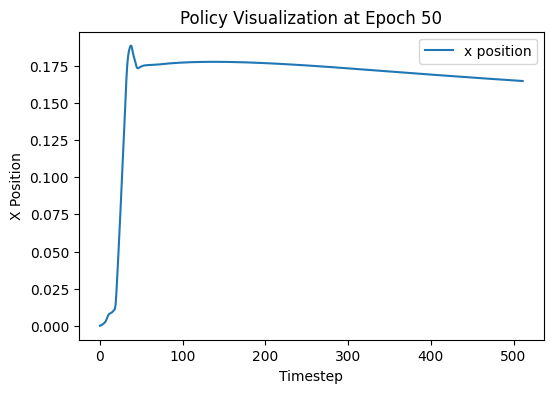

PPO Training with Debug:   7%|▋         | 68/1000 [02:25<30:58,  1.99s/it, Epoch=67, MeanReward=0.022, PolicyLoss=0.0446, ValueLoss=75.5646, Entropy=-0.084, VarPenalty=0.058, Smoothness=0.626]    

[DEBUG] New best mean reward: 0.022, model saved.


PPO Training with Debug:   7%|▋         | 73/1000 [02:36<34:43,  2.25s/it, Epoch=72, MeanReward=0.070, PolicyLoss=0.0486, ValueLoss=85.5165, Entropy=-0.086, VarPenalty=0.058, Smoothness=0.628] 

[DEBUG] New best mean reward: 0.070, model saved.


PPO Training with Debug:   9%|▊         | 86/1000 [03:02<29:58,  1.97s/it, Epoch=85, MeanReward=0.105, PolicyLoss=0.0343, ValueLoss=49.1072, Entropy=-0.088, VarPenalty=0.058, Smoothness=0.558] 

[DEBUG] New best mean reward: 0.105, model saved.


PPO Training with Debug:   9%|▉         | 89/1000 [03:08<30:19,  2.00s/it, Epoch=88, MeanReward=0.182, PolicyLoss=0.0365, ValueLoss=60.1885, Entropy=-0.085, VarPenalty=0.059, Smoothness=0.537]

[DEBUG] New best mean reward: 0.182, model saved.


PPO Training with Debug:   9%|▉         | 92/1000 [03:14<29:33,  1.95s/it, Epoch=91, MeanReward=0.269, PolicyLoss=0.1823, ValueLoss=72.2899, Entropy=-0.081, VarPenalty=0.059, Smoothness=0.554]

[DEBUG] New best mean reward: 0.269, model saved.


PPO Training with Debug:  10%|█         | 100/1000 [03:33<31:39,  2.11s/it, Epoch=100, MeanReward=0.040, PolicyLoss=0.0446, ValueLoss=43.0781, Entropy=-0.085, VarPenalty=0.058, Smoothness=0.627]/home/pilcsimo/CVUT/UROB/hw5-rl/.venv/lib/python3.11/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


Environment ready


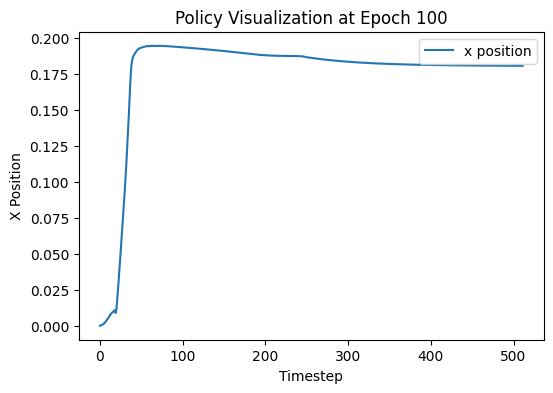

PPO Training with Debug:  15%|█▌        | 150/1000 [05:25<28:09,  1.99s/it, Epoch=150, MeanReward=0.283, PolicyLoss=0.0203, ValueLoss=17.0425, Entropy=-0.100, VarPenalty=0.058, Smoothness=0.414]   

[DEBUG] New best mean reward: 0.283, model saved.
Environment ready


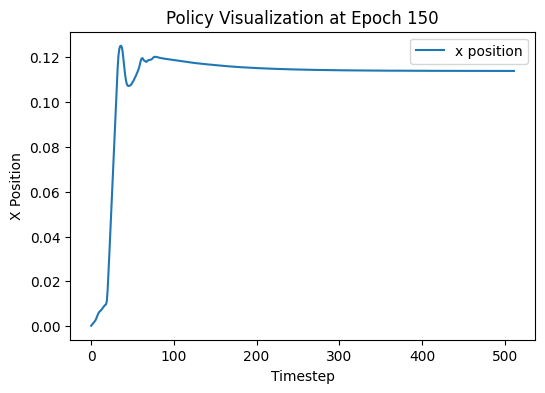

PPO Training with Debug:  15%|█▌        | 152/1000 [05:39<1:05:10,  4.61s/it, Epoch=151, MeanReward=0.360, PolicyLoss=0.0220, ValueLoss=18.1119, Entropy=-0.100, VarPenalty=0.058, Smoothness=0.434]

[DEBUG] New best mean reward: 0.360, model saved.


PPO Training with Debug:  16%|█▌        | 157/1000 [05:49<34:00,  2.42s/it, Epoch=156, MeanReward=0.409, PolicyLoss=0.0233, ValueLoss=21.6011, Entropy=-0.104, VarPenalty=0.057, Smoothness=0.448]  

[DEBUG] New best mean reward: 0.409, model saved.


PPO Training with Debug:  16%|█▌        | 160/1000 [05:56<32:30,  2.32s/it, Epoch=159, MeanReward=0.425, PolicyLoss=0.0289, ValueLoss=13.9152, Entropy=-0.100, VarPenalty=0.058, Smoothness=0.449]

[DEBUG] New best mean reward: 0.425, model saved.


PPO Training with Debug:  16%|█▋        | 163/1000 [06:02<30:43,  2.20s/it, Epoch=162, MeanReward=0.487, PolicyLoss=0.0439, ValueLoss=21.8521, Entropy=-0.100, VarPenalty=0.058, Smoothness=0.436]

[DEBUG] New best mean reward: 0.487, model saved.


PPO Training with Debug:  17%|█▋        | 167/1000 [06:10<28:54,  2.08s/it, Epoch=166, MeanReward=0.535, PolicyLoss=0.0244, ValueLoss=18.0008, Entropy=-0.103, VarPenalty=0.058, Smoothness=0.438]

[DEBUG] New best mean reward: 0.535, model saved.


PPO Training with Debug:  17%|█▋        | 168/1000 [06:13<29:05,  2.10s/it, Epoch=167, MeanReward=0.645, PolicyLoss=0.0263, ValueLoss=21.5113, Entropy=-0.102, VarPenalty=0.058, Smoothness=0.466]

[DEBUG] New best mean reward: 0.645, model saved.


PPO Training with Debug:  17%|█▋        | 170/1000 [06:17<28:45,  2.08s/it, Epoch=169, MeanReward=0.743, PolicyLoss=0.0279, ValueLoss=22.3387, Entropy=-0.105, VarPenalty=0.058, Smoothness=0.451]

[DEBUG] New best mean reward: 0.743, model saved.


PPO Training with Debug:  17%|█▋        | 172/1000 [06:21<29:44,  2.16s/it, Epoch=171, MeanReward=0.815, PolicyLoss=0.0304, ValueLoss=17.9645, Entropy=-0.109, VarPenalty=0.057, Smoothness=0.485]

[DEBUG] New best mean reward: 0.815, model saved.


PPO Training with Debug:  17%|█▋        | 173/1000 [06:23<29:32,  2.14s/it, Epoch=172, MeanReward=0.882, PolicyLoss=0.0291, ValueLoss=20.8216, Entropy=-0.107, VarPenalty=0.057, Smoothness=0.487]

[DEBUG] New best mean reward: 0.882, model saved.


PPO Training with Debug:  17%|█▋        | 174/1000 [06:26<30:11,  2.19s/it, Epoch=173, MeanReward=0.928, PolicyLoss=0.0315, ValueLoss=24.6106, Entropy=-0.107, VarPenalty=0.057, Smoothness=0.469]

[DEBUG] New best mean reward: 0.928, model saved.


PPO Training with Debug:  18%|█▊        | 176/1000 [06:30<30:38,  2.23s/it, Epoch=175, MeanReward=0.933, PolicyLoss=0.0322, ValueLoss=30.9303, Entropy=-0.106, VarPenalty=0.057, Smoothness=0.520]

[DEBUG] New best mean reward: 0.933, model saved.


PPO Training with Debug:  18%|█▊        | 177/1000 [06:32<29:43,  2.17s/it, Epoch=176, MeanReward=1.023, PolicyLoss=0.0328, ValueLoss=27.6849, Entropy=-0.106, VarPenalty=0.058, Smoothness=0.544]

[DEBUG] New best mean reward: 1.023, model saved.


PPO Training with Debug:  18%|█▊        | 180/1000 [06:38<28:42,  2.10s/it, Epoch=179, MeanReward=1.080, PolicyLoss=0.0288, ValueLoss=30.7174, Entropy=-0.108, VarPenalty=0.057, Smoothness=0.516]

[DEBUG] New best mean reward: 1.080, model saved.


PPO Training with Debug:  18%|█▊        | 181/1000 [06:40<28:30,  2.09s/it, Epoch=180, MeanReward=1.182, PolicyLoss=0.0295, ValueLoss=33.4418, Entropy=-0.108, VarPenalty=0.057, Smoothness=0.532]

[DEBUG] New best mean reward: 1.182, model saved.


PPO Training with Debug:  18%|█▊        | 183/1000 [06:45<29:19,  2.15s/it, Epoch=182, MeanReward=1.294, PolicyLoss=0.0358, ValueLoss=31.4854, Entropy=-0.107, VarPenalty=0.058, Smoothness=0.545]

[DEBUG] New best mean reward: 1.294, model saved.


PPO Training with Debug:  18%|█▊        | 184/1000 [06:47<28:34,  2.10s/it, Epoch=183, MeanReward=1.351, PolicyLoss=0.0408, ValueLoss=34.7703, Entropy=-0.109, VarPenalty=0.057, Smoothness=0.556]

[DEBUG] New best mean reward: 1.351, model saved.


PPO Training with Debug:  18%|█▊        | 185/1000 [06:49<28:16,  2.08s/it, Epoch=184, MeanReward=1.494, PolicyLoss=0.0549, ValueLoss=29.9112, Entropy=-0.106, VarPenalty=0.058, Smoothness=0.542]

[DEBUG] New best mean reward: 1.494, model saved.


PPO Training with Debug:  19%|█▉        | 191/1000 [07:01<27:31,  2.04s/it, Epoch=190, MeanReward=1.747, PolicyLoss=0.0501, ValueLoss=46.4009, Entropy=-0.113, VarPenalty=0.057, Smoothness=0.614]

[DEBUG] New best mean reward: 1.747, model saved.


PPO Training with Debug:  19%|█▉        | 193/1000 [07:05<27:33,  2.05s/it, Epoch=192, MeanReward=1.859, PolicyLoss=0.0460, ValueLoss=44.4178, Entropy=-0.114, VarPenalty=0.057, Smoothness=0.605]

[DEBUG] New best mean reward: 1.859, model saved.


PPO Training with Debug:  19%|█▉        | 194/1000 [07:08<29:14,  2.18s/it, Epoch=193, MeanReward=2.116, PolicyLoss=0.0465, ValueLoss=44.4387, Entropy=-0.115, VarPenalty=0.057, Smoothness=0.650]

[DEBUG] New best mean reward: 2.116, model saved.


PPO Training with Debug:  20%|█▉        | 195/1000 [07:10<28:57,  2.16s/it, Epoch=194, MeanReward=2.123, PolicyLoss=0.0598, ValueLoss=44.9410, Entropy=-0.115, VarPenalty=0.057, Smoothness=0.697]

[DEBUG] New best mean reward: 2.123, model saved.


PPO Training with Debug:  20%|█▉        | 199/1000 [07:19<29:52,  2.24s/it, Epoch=198, MeanReward=2.223, PolicyLoss=0.0552, ValueLoss=43.0450, Entropy=-0.117, VarPenalty=0.057, Smoothness=0.716]

[DEBUG] New best mean reward: 2.223, model saved.


PPO Training with Debug:  20%|██        | 200/1000 [07:21<29:40,  2.23s/it, Epoch=199, MeanReward=2.250, PolicyLoss=0.0679, ValueLoss=44.5094, Entropy=-0.118, VarPenalty=0.057, Smoothness=0.686]

[DEBUG] New best mean reward: 2.250, model saved.


PPO Training with Debug:  20%|██        | 200/1000 [07:23<29:40,  2.23s/it, Epoch=200, MeanReward=2.133, PolicyLoss=0.0645, ValueLoss=47.9638, Entropy=-0.116, VarPenalty=0.057, Smoothness=0.670]

Environment ready


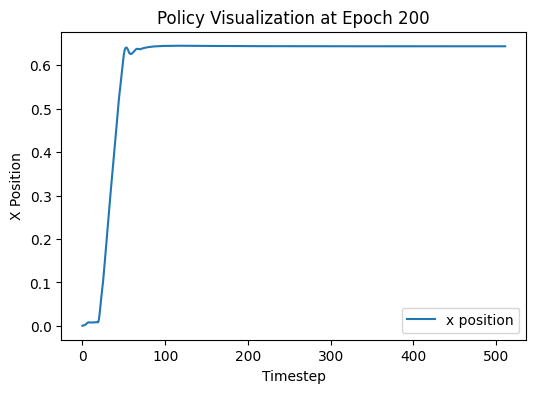

PPO Training with Debug:  20%|██        | 202/1000 [07:38<1:04:44,  4.87s/it, Epoch=201, MeanReward=2.372, PolicyLoss=0.0632, ValueLoss=46.6785, Entropy=-0.117, VarPenalty=0.057, Smoothness=0.683]

[DEBUG] New best mean reward: 2.372, model saved.


PPO Training with Debug:  20%|██        | 203/1000 [07:40<54:16,  4.09s/it, Epoch=202, MeanReward=2.671, PolicyLoss=0.0739, ValueLoss=48.4013, Entropy=-0.119, VarPenalty=0.057, Smoothness=0.707]  

[DEBUG] New best mean reward: 2.671, model saved.


PPO Training with Debug:  21%|██        | 206/1000 [07:47<38:41,  2.92s/it, Epoch=205, MeanReward=2.685, PolicyLoss=0.0559, ValueLoss=57.1616, Entropy=-0.121, VarPenalty=0.057, Smoothness=0.737]

[DEBUG] New best mean reward: 2.685, model saved.


PPO Training with Debug:  21%|██        | 207/1000 [07:49<35:35,  2.69s/it, Epoch=206, MeanReward=2.992, PolicyLoss=0.0558, ValueLoss=68.2740, Entropy=-0.122, VarPenalty=0.057, Smoothness=0.717]

[DEBUG] New best mean reward: 2.992, model saved.


PPO Training with Debug:  21%|██        | 208/1000 [07:52<33:32,  2.54s/it, Epoch=207, MeanReward=3.227, PolicyLoss=0.0501, ValueLoss=65.0561, Entropy=-0.123, VarPenalty=0.057, Smoothness=0.726]

[DEBUG] New best mean reward: 3.227, model saved.


PPO Training with Debug:  21%|██        | 210/1000 [07:56<32:13,  2.45s/it, Epoch=209, MeanReward=3.492, PolicyLoss=0.0528, ValueLoss=79.8420, Entropy=-0.123, VarPenalty=0.057, Smoothness=0.738]

[DEBUG] New best mean reward: 3.492, model saved.


PPO Training with Debug:  21%|██        | 211/1000 [07:59<31:45,  2.42s/it, Epoch=210, MeanReward=3.665, PolicyLoss=0.0600, ValueLoss=71.8964, Entropy=-0.124, VarPenalty=0.057, Smoothness=0.733]

[DEBUG] New best mean reward: 3.665, model saved.


PPO Training with Debug:  21%|██▏       | 214/1000 [08:05<29:58,  2.29s/it, Epoch=213, MeanReward=3.876, PolicyLoss=0.0851, ValueLoss=77.8802, Entropy=-0.127, VarPenalty=0.057, Smoothness=0.725]

[DEBUG] New best mean reward: 3.876, model saved.


PPO Training with Debug:  22%|██▏       | 215/1000 [08:08<29:44,  2.27s/it, Epoch=214, MeanReward=3.946, PolicyLoss=0.0914, ValueLoss=78.4966, Entropy=-0.130, VarPenalty=0.057, Smoothness=0.759]

[DEBUG] New best mean reward: 3.946, model saved.


PPO Training with Debug:  22%|██▏       | 217/1000 [08:12<28:36,  2.19s/it, Epoch=216, MeanReward=4.091, PolicyLoss=0.0628, ValueLoss=82.0398, Entropy=-0.130, VarPenalty=0.057, Smoothness=0.714]

[DEBUG] New best mean reward: 4.091, model saved.


PPO Training with Debug:  22%|██▏       | 219/1000 [08:16<29:16,  2.25s/it, Epoch=218, MeanReward=4.336, PolicyLoss=0.0956, ValueLoss=84.6881, Entropy=-0.133, VarPenalty=0.057, Smoothness=0.736]

[DEBUG] New best mean reward: 4.336, model saved.


PPO Training with Debug:  22%|██▏       | 222/1000 [08:23<29:29,  2.27s/it, Epoch=221, MeanReward=4.549, PolicyLoss=0.0784, ValueLoss=94.7102, Entropy=-0.131, VarPenalty=0.057, Smoothness=0.749]

[DEBUG] New best mean reward: 4.549, model saved.


PPO Training with Debug:  22%|██▎       | 225/1000 [08:30<28:25,  2.20s/it, Epoch=224, MeanReward=4.795, PolicyLoss=0.0596, ValueLoss=92.7869, Entropy=-0.134, VarPenalty=0.057, Smoothness=0.764]

[DEBUG] New best mean reward: 4.795, model saved.


PPO Training with Debug:  24%|██▍       | 239/1000 [08:59<26:28,  2.09s/it, Epoch=238, MeanReward=5.033, PolicyLoss=0.0867, ValueLoss=111.1924, Entropy=-0.135, VarPenalty=0.057, Smoothness=0.749]

[DEBUG] New best mean reward: 5.033, model saved.


PPO Training with Debug:  24%|██▍       | 240/1000 [09:01<26:42,  2.11s/it, Epoch=239, MeanReward=5.112, PolicyLoss=0.0653, ValueLoss=110.5990, Entropy=-0.137, VarPenalty=0.057, Smoothness=0.754]

[DEBUG] New best mean reward: 5.112, model saved.


PPO Training with Debug:  25%|██▍       | 247/1000 [09:15<25:47,  2.06s/it, Epoch=246, MeanReward=5.253, PolicyLoss=0.0709, ValueLoss=111.6078, Entropy=-0.139, VarPenalty=0.057, Smoothness=0.752]

[DEBUG] New best mean reward: 5.253, model saved.


PPO Training with Debug:  25%|██▍       | 249/1000 [09:20<25:55,  2.07s/it, Epoch=248, MeanReward=5.293, PolicyLoss=0.0871, ValueLoss=104.6031, Entropy=-0.140, VarPenalty=0.057, Smoothness=0.760]

[DEBUG] New best mean reward: 5.293, model saved.


PPO Training with Debug:  25%|██▌       | 250/1000 [09:22<26:34,  2.13s/it, Epoch=249, MeanReward=5.430, PolicyLoss=0.0791, ValueLoss=128.5873, Entropy=-0.140, VarPenalty=0.057, Smoothness=0.760]

[DEBUG] New best mean reward: 5.430, model saved.


PPO Training with Debug:  25%|██▌       | 250/1000 [09:24<26:34,  2.13s/it, Epoch=250, MeanReward=5.211, PolicyLoss=0.0778, ValueLoss=106.1868, Entropy=-0.136, VarPenalty=0.057, Smoothness=0.726]

Environment ready


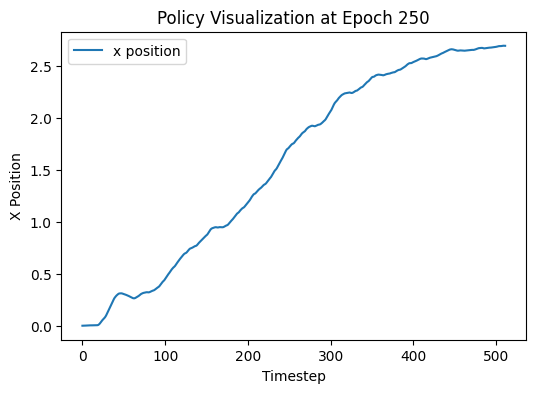

PPO Training with Debug:  26%|██▌       | 257/1000 [09:49<31:48,  2.57s/it, Epoch=256, MeanReward=5.792, PolicyLoss=0.0684, ValueLoss=114.8699, Entropy=-0.141, VarPenalty=0.057, Smoothness=0.712]  

[DEBUG] New best mean reward: 5.792, model saved.


PPO Training with Debug:  26%|██▌       | 259/1000 [09:54<28:44,  2.33s/it, Epoch=258, MeanReward=5.974, PolicyLoss=0.0961, ValueLoss=122.8767, Entropy=-0.141, VarPenalty=0.057, Smoothness=0.713]

[DEBUG] New best mean reward: 5.974, model saved.


PPO Training with Debug:  26%|██▌       | 260/1000 [09:56<27:08,  2.20s/it, Epoch=259, MeanReward=6.032, PolicyLoss=0.0812, ValueLoss=111.2817, Entropy=-0.142, VarPenalty=0.057, Smoothness=0.697]

[DEBUG] New best mean reward: 6.032, model saved.


PPO Training with Debug:  26%|██▌       | 262/1000 [10:00<25:57,  2.11s/it, Epoch=261, MeanReward=6.467, PolicyLoss=0.0794, ValueLoss=100.1200, Entropy=-0.144, VarPenalty=0.057, Smoothness=0.726]

[DEBUG] New best mean reward: 6.467, model saved.


PPO Training with Debug:  27%|██▋       | 270/1000 [10:15<23:33,  1.94s/it, Epoch=269, MeanReward=6.814, PolicyLoss=0.0768, ValueLoss=113.6173, Entropy=-0.145, VarPenalty=0.056, Smoothness=0.724]

[DEBUG] New best mean reward: 6.814, model saved.


PPO Training with Debug:  28%|██▊       | 281/1000 [10:38<25:46,  2.15s/it, Epoch=280, MeanReward=6.868, PolicyLoss=0.0830, ValueLoss=129.3074, Entropy=-0.137, VarPenalty=0.057, Smoothness=0.675]

[DEBUG] New best mean reward: 6.868, model saved.


PPO Training with Debug:  29%|██▉       | 292/1000 [11:01<23:55,  2.03s/it, Epoch=291, MeanReward=7.360, PolicyLoss=0.0485, ValueLoss=116.8906, Entropy=-0.141, VarPenalty=0.057, Smoothness=0.685]

[DEBUG] New best mean reward: 7.360, model saved.


PPO Training with Debug:  29%|██▉       | 293/1000 [11:03<23:44,  2.01s/it, Epoch=292, MeanReward=7.743, PolicyLoss=0.0589, ValueLoss=99.1101, Entropy=-0.144, VarPenalty=0.057, Smoothness=0.705] 

[DEBUG] New best mean reward: 7.743, model saved.


PPO Training with Debug:  30%|███       | 300/1000 [11:19<23:35,  2.02s/it, Epoch=300, MeanReward=6.519, PolicyLoss=0.0523, ValueLoss=120.2194, Entropy=-0.142, VarPenalty=0.057, Smoothness=0.679]

Environment ready


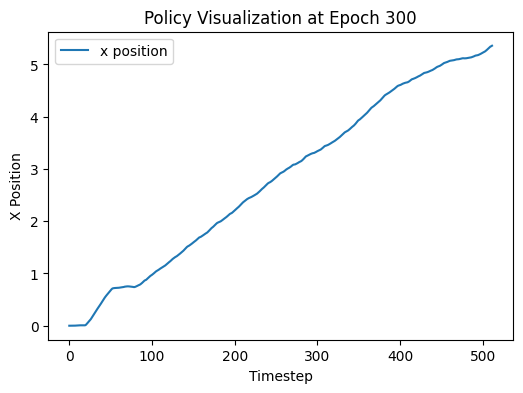

PPO Training with Debug:  30%|███       | 302/1000 [11:34<53:36,  4.61s/it, Epoch=301, MeanReward=8.044, PolicyLoss=0.0713, ValueLoss=115.7995, Entropy=-0.147, VarPenalty=0.057, Smoothness=0.697]  

[DEBUG] New best mean reward: 8.044, model saved.


PPO Training with Debug:  35%|███▌      | 350/1000 [13:12<20:58,  1.94s/it, Epoch=350, MeanReward=6.462, PolicyLoss=0.0701, ValueLoss=174.1256, Entropy=-0.130, VarPenalty=0.058, Smoothness=0.666]

Environment ready


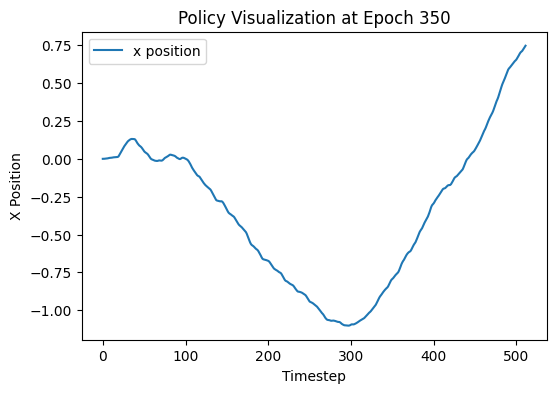

PPO Training with Debug:  36%|███▌      | 357/1000 [13:37<27:01,  2.52s/it, Epoch=356, MeanReward=8.276, PolicyLoss=0.1229, ValueLoss=162.4761, Entropy=-0.140, VarPenalty=0.058, Smoothness=0.707]  

[DEBUG] New best mean reward: 8.276, model saved.


PPO Training with Debug:  38%|███▊      | 376/1000 [14:15<20:56,  2.01s/it, Epoch=375, MeanReward=8.689, PolicyLoss=0.0465, ValueLoss=153.4450, Entropy=-0.139, VarPenalty=0.058, Smoothness=0.656]

[DEBUG] New best mean reward: 8.689, model saved.


PPO Training with Debug:  38%|███▊      | 379/1000 [14:21<20:55,  2.02s/it, Epoch=378, MeanReward=8.734, PolicyLoss=0.0536, ValueLoss=138.1941, Entropy=-0.141, VarPenalty=0.058, Smoothness=0.662]

[DEBUG] New best mean reward: 8.734, model saved.


PPO Training with Debug:  39%|███▉      | 392/1000 [14:48<21:30,  2.12s/it, Epoch=391, MeanReward=9.370, PolicyLoss=0.0498, ValueLoss=90.6017, Entropy=-0.142, VarPenalty=0.058, Smoothness=0.657] 

[DEBUG] New best mean reward: 9.370, model saved.


PPO Training with Debug:  40%|███▉      | 398/1000 [15:01<20:05,  2.00s/it, Epoch=397, MeanReward=9.459, PolicyLoss=0.0456, ValueLoss=105.2829, Entropy=-0.147, VarPenalty=0.058, Smoothness=0.696]

[DEBUG] New best mean reward: 9.459, model saved.


PPO Training with Debug:  40%|████      | 400/1000 [15:07<20:17,  2.03s/it, Epoch=400, MeanReward=9.771, PolicyLoss=0.0499, ValueLoss=102.9736, Entropy=-0.145, VarPenalty=0.058, Smoothness=0.645]

[DEBUG] New best mean reward: 9.771, model saved.
Environment ready


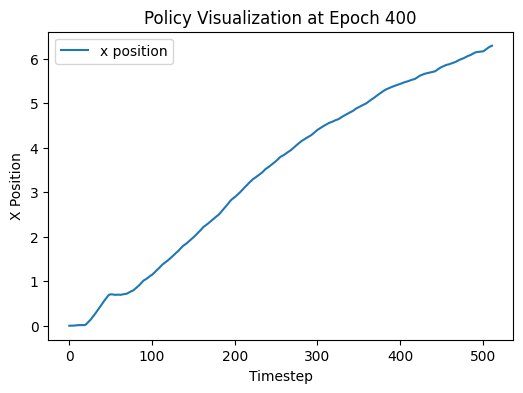

PPO Training with Debug:  40%|████      | 403/1000 [15:23<37:46,  3.80s/it, Epoch=402, MeanReward=9.954, PolicyLoss=0.0571, ValueLoss=106.5474, Entropy=-0.147, VarPenalty=0.058, Smoothness=0.663]

[DEBUG] New best mean reward: 9.954, model saved.


PPO Training with Debug:  41%|████      | 406/1000 [15:29<25:46,  2.60s/it, Epoch=405, MeanReward=9.957, PolicyLoss=0.0558, ValueLoss=117.3821, Entropy=-0.148, VarPenalty=0.058, Smoothness=0.646]

[DEBUG] New best mean reward: 9.957, model saved.


PPO Training with Debug:  41%|████      | 407/1000 [15:31<24:54,  2.52s/it, Epoch=406, MeanReward=10.016, PolicyLoss=0.0571, ValueLoss=123.0761, Entropy=-0.149, VarPenalty=0.058, Smoothness=0.649]

[DEBUG] New best mean reward: 10.016, model saved.


PPO Training with Debug:  41%|████      | 410/1000 [15:37<22:28,  2.29s/it, Epoch=409, MeanReward=10.553, PolicyLoss=0.0661, ValueLoss=112.6183, Entropy=-0.148, VarPenalty=0.058, Smoothness=0.638]

[DEBUG] New best mean reward: 10.553, model saved.


PPO Training with Debug:  41%|████▏     | 414/1000 [15:45<19:57,  2.04s/it, Epoch=413, MeanReward=10.738, PolicyLoss=0.0837, ValueLoss=103.9295, Entropy=-0.152, VarPenalty=0.058, Smoothness=0.654]

[DEBUG] New best mean reward: 10.738, model saved.


PPO Training with Debug:  42%|████▏     | 419/1000 [15:55<19:19,  2.00s/it, Epoch=418, MeanReward=10.751, PolicyLoss=0.0724, ValueLoss=117.5702, Entropy=-0.150, VarPenalty=0.058, Smoothness=0.624]

[DEBUG] New best mean reward: 10.751, model saved.


PPO Training with Debug:  42%|████▏     | 422/1000 [16:01<19:31,  2.03s/it, Epoch=421, MeanReward=10.779, PolicyLoss=0.0685, ValueLoss=112.4413, Entropy=-0.154, VarPenalty=0.058, Smoothness=0.657]

[DEBUG] New best mean reward: 10.779, model saved.


PPO Training with Debug:  42%|████▏     | 423/1000 [16:03<19:24,  2.02s/it, Epoch=422, MeanReward=11.097, PolicyLoss=0.0820, ValueLoss=96.2098, Entropy=-0.154, VarPenalty=0.058, Smoothness=0.652] 

[DEBUG] New best mean reward: 11.097, model saved.


PPO Training with Debug:  45%|████▌     | 450/1000 [17:00<19:07,  2.09s/it, Epoch=450, MeanReward=10.558, PolicyLoss=0.0444, ValueLoss=144.3748, Entropy=-0.155, VarPenalty=0.057, Smoothness=0.679]

Environment ready


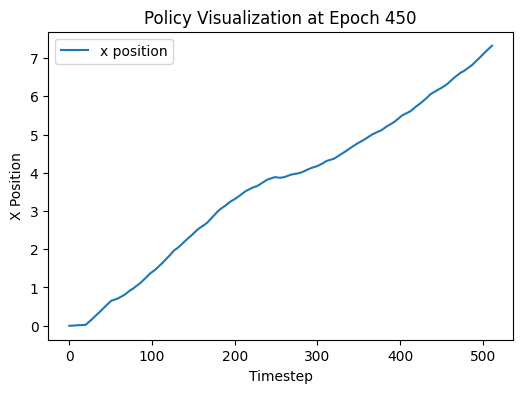

PPO Training with Debug:  45%|████▌     | 452/1000 [17:15<43:36,  4.78s/it, Epoch=451, MeanReward=11.304, PolicyLoss=0.0464, ValueLoss=120.7673, Entropy=-0.154, VarPenalty=0.057, Smoothness=0.669]

[DEBUG] New best mean reward: 11.304, model saved.


PPO Training with Debug:  46%|████▌     | 455/1000 [17:21<26:52,  2.96s/it, Epoch=454, MeanReward=11.900, PolicyLoss=0.0525, ValueLoss=110.9197, Entropy=-0.156, VarPenalty=0.057, Smoothness=0.675]

[DEBUG] New best mean reward: 11.900, model saved.


PPO Training with Debug:  47%|████▋     | 472/1000 [17:54<17:04,  1.94s/it, Epoch=471, MeanReward=11.952, PolicyLoss=0.1222, ValueLoss=122.5772, Entropy=-0.155, VarPenalty=0.057, Smoothness=0.676]

[DEBUG] New best mean reward: 11.952, model saved.


PPO Training with Debug:  48%|████▊     | 480/1000 [18:10<16:42,  1.93s/it, Epoch=479, MeanReward=12.252, PolicyLoss=0.0561, ValueLoss=102.8153, Entropy=-0.153, VarPenalty=0.058, Smoothness=0.663]

[DEBUG] New best mean reward: 12.252, model saved.


PPO Training with Debug:  49%|████▉     | 494/1000 [18:37<16:06,  1.91s/it, Epoch=493, MeanReward=12.424, PolicyLoss=0.0658, ValueLoss=119.4744, Entropy=-0.163, VarPenalty=0.057, Smoothness=0.684]

[DEBUG] New best mean reward: 12.424, model saved.


PPO Training with Debug:  50%|█████     | 500/1000 [18:51<16:24,  1.97s/it, Epoch=500, MeanReward=10.684, PolicyLoss=0.0684, ValueLoss=161.2975, Entropy=-0.163, VarPenalty=0.057, Smoothness=0.717]

Environment ready


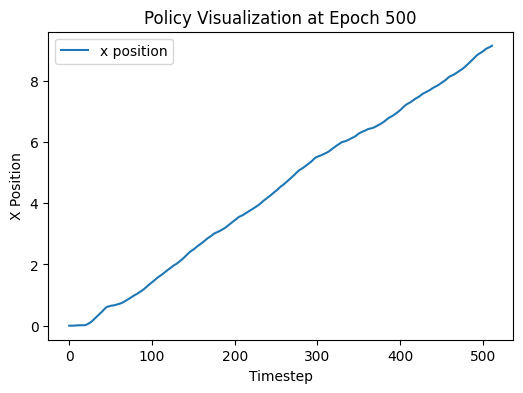

PPO Training with Debug:  52%|█████▏    | 516/1000 [19:34<16:26,  2.04s/it, Epoch=515, MeanReward=12.585, PolicyLoss=0.0629, ValueLoss=116.6560, Entropy=-0.166, VarPenalty=0.057, Smoothness=0.675]

[DEBUG] New best mean reward: 12.585, model saved.


PPO Training with Debug:  53%|█████▎    | 529/1000 [20:00<15:47,  2.01s/it, Epoch=528, MeanReward=12.990, PolicyLoss=0.1144, ValueLoss=143.7362, Entropy=-0.165, VarPenalty=0.057, Smoothness=0.677]

[DEBUG] New best mean reward: 12.990, model saved.


PPO Training with Debug:  54%|█████▍    | 539/1000 [20:20<15:02,  1.96s/it, Epoch=538, MeanReward=13.407, PolicyLoss=0.0581, ValueLoss=152.9214, Entropy=-0.165, VarPenalty=0.057, Smoothness=0.670]

[DEBUG] New best mean reward: 13.407, model saved.


PPO Training with Debug:  55%|█████▌    | 550/1000 [20:44<14:53,  1.98s/it, Epoch=550, MeanReward=11.484, PolicyLoss=0.0616, ValueLoss=271.1701, Entropy=-0.163, VarPenalty=0.057, Smoothness=0.655]

Environment ready


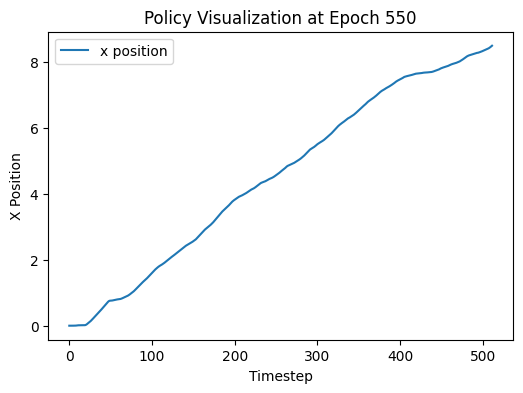

PPO Training with Debug:  60%|██████    | 600/1000 [22:35<13:01,  1.95s/it, Epoch=600, MeanReward=9.581, PolicyLoss=0.0403, ValueLoss=426.1741, Entropy=-0.161, VarPenalty=0.057, Smoothness=0.623] 

Environment ready


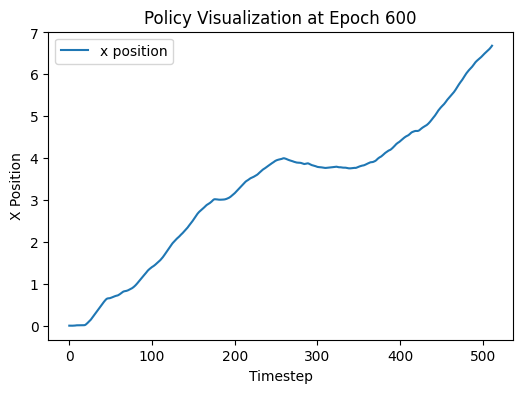

PPO Training with Debug:  64%|██████▍   | 639/1000 [24:06<12:21,  2.05s/it, Epoch=638, MeanReward=7.196, PolicyLoss=0.0310, ValueLoss=375.8108, Entropy=-0.146, VarPenalty=0.058, Smoothness=0.563]/home/pilcsimo/CVUT/UROB/hw5-rl/WalkerPolicy.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't hav

[DEBUG] Training restarted from checkpoint due to lack of improvement.


PPO Training with Debug:  65%|██████▌   | 650/1000 [24:30<11:58,  2.05s/it, Epoch=650, MeanReward=11.743, PolicyLoss=0.0452, ValueLoss=175.0937, Entropy=-0.160, VarPenalty=0.057, Smoothness=0.651]

Environment ready


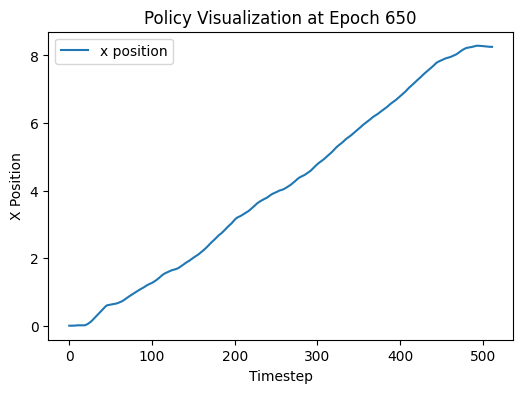

PPO Training with Debug:  70%|███████   | 700/1000 [26:30<10:02,  2.01s/it, Epoch=700, MeanReward=9.257, PolicyLoss=0.0661, ValueLoss=317.8713, Entropy=-0.149, VarPenalty=0.058, Smoothness=0.564] 

Environment ready


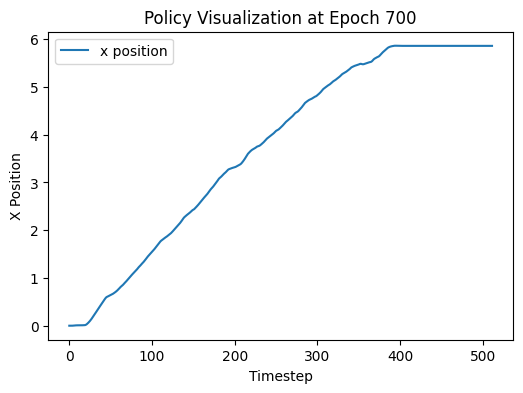

PPO Training with Debug:  74%|███████▍  | 741/1000 [28:09<08:42,  2.02s/it, Epoch=740, MeanReward=7.690, PolicyLoss=0.0384, ValueLoss=230.2869, Entropy=-0.146, VarPenalty=0.058, Smoothness=0.539] 

[DEBUG] Training restarted from checkpoint due to lack of improvement.


PPO Training with Debug:  75%|███████▌  | 750/1000 [28:29<08:16,  1.99s/it, Epoch=750, MeanReward=11.212, PolicyLoss=0.0646, ValueLoss=210.4555, Entropy=-0.163, VarPenalty=0.057, Smoothness=0.675]

Environment ready


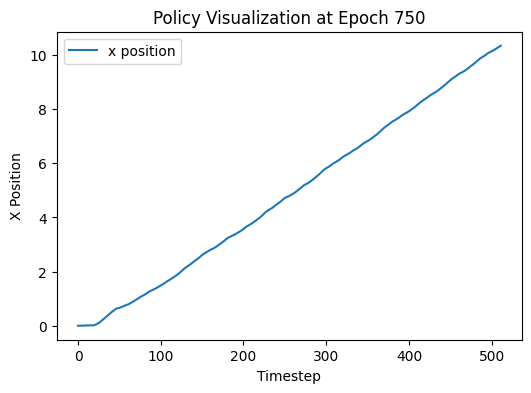

PPO Training with Debug:  79%|███████▉  | 794/1000 [30:09<07:49,  2.28s/it, Epoch=793, MeanReward=11.035, PolicyLoss=0.0578, ValueLoss=317.1537, Entropy=-0.155, VarPenalty=0.057, Smoothness=0.614]


KeyboardInterrupt: 

In [7]:
mean_rewards, p_losses, v_losses = run_ppo_training_debug() # run the training
mean_rewards, p_losses, v_losses = run_ppo_training_debug(True) # refine model


## Debug how the quadruped moves

In [ ]:
def debug_wave_actions():
    env = WalkerEnv({'N': 1, 'vis': True, 'track': 0})
    obs = env.reset()

    for step in range(500):
        # example: wave each joint from -1 to +1 over time
        wave = np.sin(step * 0.3)  # range ~ [-0.5, 0.5]
        action = np.array([-2, wave, 2, wave, -2.0, 3, 2.0, 3])  # shape (8,)
        obs, rewards = env.vector_step(action)
        local_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)
        q_wxyz = obs[0][3:7]  # [w, x, y, z]
        # rotate local_up:
        up_world = rotate_vector_by_quaternion(local_up, q_wxyz)
            
        # if up_world.z < 0 => flipped
        print (f"step: {step} UW:{up_world[2]}")
        if up_world[2] < -0.9:
            print(f"Robot flipped at time {step}")
        # does the robot's legs wave? do we see any movement?

    env.close()

debug_wave_actions()


## Visualise the trained quadruped

In [ ]:
# This is the configuration for the Walker environment
# N is the number of robots controlled in parallel
# vis is a boolean flag to enable visualization
# !! IMPORTANT track is an integer index to enable camera tracking of a particular robot (indexed by the value of the argument), this is useful when evaluating the performance of the policy after training
# reward_fcn is the reward function that the environment will use to calculate the reward
T = 1000
x = -1000
N = 1

env = WalkerEnv({'N': N, 'vis': VISUALIZE, "track": 0, "reward_fcn": walker_reward})
obs = env.vector_reset()  # shape (4, 29)
policy = WalkerPolicy()
policy.load_weights()

for i in range(T):
    # obs is now shape (4, 29)
    obs_tensor = torch.tensor(obs, dtype=torch.float32)  # shape (N, 29)
    actions_tensor = policy.determine_actions(obs_tensor)  # shape (N, 8)

    # Flatten to (32,) for env.vector_step
    actions_np = actions_tensor.cpu().numpy().reshape(-1)
    obs, reward = env.vector_step(actions_np)  # returns new obs, reward for all N walkers

    # For tracking the maximum x across all walkers:
    # obs is a list of length 4, each a (29,)-shaped array
    for w in range(N):
        x = max(x, obs[w][0])

env.close()
print(f"After {T} steps, the maximum x value reached was {x}")
